In [1]:
import numpy as np
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
import string

from collections import Counter
from IPython.display import display as dsp
#from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import linear_model

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from gensim import corpora, models

from scipy import stats

#Stopwords dictionary
stop = nltk.corpus.stopwords.words('english')

In [2]:
#Instantiate truncated SVD for dimensionality reduction and create normalized pipeline
svd = TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy = False))

#Instantiate stemmer, lemmatizer, and tokenizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Instantiate linear model
lasso = linear_model.Lasso(alpha=.35)

In [3]:
# Utility function change entries in dataframe into collection of stemmed terms
def word_parser(series):
    texts = []
    
    for entry in series:
        
        #Lowercase
        raw = entry.lower()
        
        #tokenize
        tokens = w_tokenizer.tokenize(raw)
        
        #Removing stopwords and lemmatization
        
        stemmed_tokens = []
        for i in tokens:
            if i not in stop:
                stemmed_tokens.append(lemmatizer.lemmatize(i))
        
        #Add to list
        texts.append(stemmed_tokens)
        
    return texts
        

#Clean Text
def text_cleaner(text):
    
    #Ensure all excess whitespace is removed, lowercase
    text = ' '.join(text.split())
    
    #Remove non-alphabetical characters(and not spaces)
    text = ''.join(c for c in text if c.isalpha() or c == ' ')
    
    #Lemmatize
    #text_array = w_tokenizer.tokenize(text)
    #for word in text_array:
        #text.join(lemmatizer.lemmatize(word))
    #text = ' '.join(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text))
    
    return text

#String all parts of an array into one long string
def stringer(series):
    results = ''
    for entry in series:
        results += str(entry)
        
    return results

#Function to perform tfidf on a series of document and return a dataframe of terms and their score.
def tfidf_this(series, tfidf):
    #Fit model
    x = tfidf.fit_transform(series)

    #Map results to same dataframe
    tfidf_results = pd.DataFrame(index = tfidf.vocabulary_)
    #tfidf_results['term'] = tfidf.vocabulary_
    tfidf_results['score'] = tfidf.idf_
    
    #Return results
    return tfidf_results

In [4]:
#Instantiate our tf-idf model
tfidf = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english',
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

Data taken from kaggle
https://www.kaggle.com/zynicide/wine-reviews

# The Wine Review List

What we have here is a dataset of wine reviews from the Wine Enthusiast magazine (https://www.winemag.com/?s=&drink_type=wine). This dataset has gained popularity as a training set to measure the capabilities of various classifiers, clustering algorithms and natural language processing models.

There are several reasons why this dataset is so good for testing machine learning processes. First, the immense size of the dataset (at over 100'000 entries, each with a paragraph of text written by dozens of unique authors, with several other unique attributes such as title of the wine, type of wine, country of origin et al.

There are dozens of potential projects, such as supervised learning techniques involving predicting the authorship of the wine review based on the metrics of the review itself, or unsupervised techniques such as clustering reviews and wine types.

## The Data

We will first explore the form our data takes. We import the data as a pandas dataframe from a CSV file. There are several potential projects we could do using only a handful of columns from the original dataset, and thankfully, not very many entries countained null values we had to get rid of.

We will start by exploring a subset of the columns available from the raw dataset, being: 'description', 'title', 'country', 'taster_name', and 'variety'.

In [5]:
#Import raw data
raw = pd.read_csv('wine-reviews/winemag-data-130k-v2.csv')
print('The raw dataset has {} columns.'.format(len(raw.columns)))
print(raw.columns)

#Pull out columns of interest
data = raw[['description', 'points', 'price', 'title', 'country', 'taster_name', 'variety']]
data.dropna(inplace = True)

#Chech final dataframe dimensions
print("Original raw data shape:{}".format(raw.shape))
print("Dataframe shape:{}".format(data.shape))

#Check data formatting
#dsp(data.head())
#print(len(data.variety.unique()))


#Clean text
data['description'] = data['description'].apply(lambda x: text_cleaner(x))

print(data['description'][1])

The raw dataset has 14 columns.
Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')
Original raw data shape:(129971, 14)
Dataframe shape:(96420, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


This is ripe and fruity a wine that is smooth while still structured Firm tannins are filled out with juicy red berry fruits and freshened with acidity Its already drinkable although it will certainly be better from 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Our Business Goal

Suppose we were a winery looking to perfect our formula with the goal of being a hit with the critics and either maximizing or minimizing the price point. Our approach to this problem would be to use natural language processing to find what concepts (flavors, scents et al) most strongly correlate to our business goals.

For our purposes, we will assume that the price of the wine perfectly correlates with the manufacturing cost, and an optimal solution would be to maximize the quality to price ratio. We will first formulate an outcome variable and measure its intrisic properties.

There are a total of 381 unique prices over 96420 reviews.
There are a total of 21 unique ratings over 96420 reviews.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'Number of Observations')

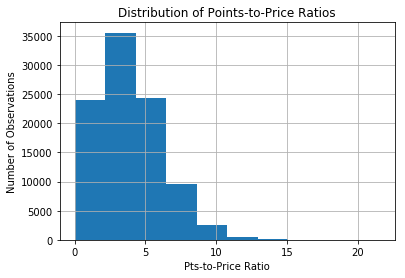

In [6]:
print('There are a total of {} unique prices over {} reviews.'
      .format(len(data['price'].unique()), data.shape[0]))

print('There are a total of {} unique ratings over {} reviews.'
      .format(len(data['points'].unique()), data.shape[0]))

#Create outcome variable
data['points-to-price'] = data['points'] / data['price']

#Plot histogram of outcome
plt.title('Distribution of Points-to-Price Ratios')
data['points-to-price'].hist()

####Labels####
plt.xlabel('Pts-to-Price Ratio')
plt.ylabel('Number of Observations')

## Straight Points-to-Price Model

__The Good News__

There is nothing too odd going on in the distribution of the results. We have one peak in the 

__The Bad News__

Our business outcome is right skewed. This will have to be adjusted.

,description,points-to-price
1,This is ripe and fruity a wine that is smooth ...,5.800000
2,Tart and snappy the flavors of lime flesh and ...,6.214286
3,Pineapple rind lemon pith and orange blossom s...,6.692308
4,Much like the regular bottling from this come...,1.338462
5,Blackberry and raspberry aromas show a typical...,5.800000


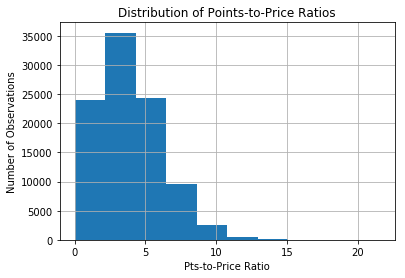

In [7]:
#Fix right skew
#data['points-to-price']

#Plot histogram of outcome
plt.title('Distribution of Points-to-Price Ratios')
data['points-to-price'].hist()

####Labels####
plt.xlabel('Pts-to-Price Ratio')
plt.ylabel('Number of Observations')

#Show description|pts-to-price table
dsp(data[['description', 'points-to-price']].head())

## Grouping

The first thing we want to work with is grouping reviews by type. Since reviews tend to mention properties of wine associated with its variety, we should be able to predict the variety of wine based on its review.

To accomplish this, we will be looking at the top 10 most reviewed varieties of wine. We will sample 40 reviews from each of these varieties to ensure that we avoid class imbalance, as well as drastically reduce the computational cost of processing our 'proof of concept' stage before we roll the model out to the entire dataset. Afterwords, we will string these reviews together to form 'books' associated with each variety.

Looking at the list of top 20 most reviewed wines, we can see a few 'such and such' style red blend. We are not yet interested in treating different subvarients of wines as separate varieties, so we will be particularly selective with what varieties of wine we include.

In [8]:
#20 most reviewed varieties
#print('20 Most Reviewed Wine Varieties:\n',
#      data['variety'].value_counts()[0:20])

#Top main variety list
wine_types = ['Pinot Noir', 'Chardonnay', 'Red Blend', 'Cabernet Sauvignon', 'Riesling', 'Sauvignon Blanc', 'Syrah',
       'Rosé', 'Malbec', 'Merlot']

#We will be using this dataset as a condensed representation of
#our full dataset, this allows us to use more intensive NLP methods
data_cond = pd.DataFrame(columns = data.columns)

for variety in wine_types:
    data_cond = pd.concat([data_cond, 
               data[data['variety'] == variety].sample(n = 40, random_state = 101)])

print('Original dataframe shape: ', data.shape)
print('Balanced dataframe shape: ', data_cond.shape)

Original dataframe shape:  (96420, 8)
Balanced dataframe shape:  (400, 8)


Our condensed data contains 16 unique authors


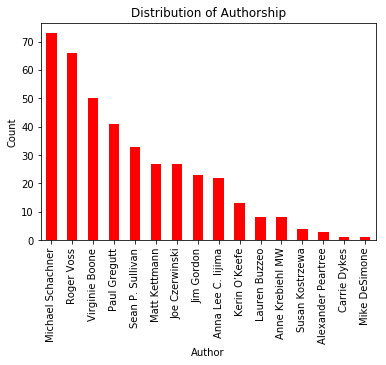


List of authors:

Michael Schachner     73
Roger Voss            66
Virginie Boone        50
Paul Gregutt          41
Sean P. Sullivan      33
Matt Kettmann         27
Joe Czerwinski        27
Jim Gordon            23
Anna Lee C. Iijima    22
Kerin O’Keefe         13
Lauren Buzzeo          8
Anne Krebiehl MW       8
Susan Kostrzewa        4
Alexander Peartree     3
Carrie Dykes           1
Mike DeSimone          1
Name: taster_name, dtype: int64


In [9]:
#We shall now look at what authors typically write in these categories.
print('Our condensed data contains {} unique authors'.format(len(data_cond['taster_name'].unique())))

#Plot distribution of authorship
plt.title('Distribution of Authorship')
data_cond['taster_name'].value_counts().plot(kind = 'bar', color = 'red')
plt.xlabel('Author')
plt.ylabel('Count')
plt.show()

print('\nList of authors:\n')
print(data_cond['taster_name'].value_counts())

### Authorship

Let us explore the correlation between authorship and variety. If authors tend to write for particular wines, they might impart their particular linguistic style to their review which could impact in some small way the results of our model.

In [10]:
#We will now compare what authors tend to review what wine.
auth_type = data_cond[['taster_name', 'variety']]

#To do this, we will perform chi^2 testing, first we must create a contingency table
contingency_table = pd.crosstab(data_cond['taster_name'], data_cond['variety'], margins = True)

print('Author to Variety Contingency Table\n')
#dsp(contingency_table)


#Plot histogram for every author based on how many of each variety they reviewed
#plt.title('Author to Variety Heatmap')
#sns.PairGrid(contingency_table)
#plt.show()

#We now run our chi^2 test on the contingency table we just generated
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print('Chi-Squared Test Statistic: {}'.format(chi2))
print('P-Value: {}'.format(p))
print('Degrees of Freedom: {}'.format(dof))
#print('Expected: {}'.format(expected))

#Statistical analysis is overkill, observe histogram per person

Author to Variety Contingency Table

Chi-Squared Test Statistic: 607.2239341996747
P-Value: 2.659296425076017e-53
Degrees of Freedom: 160


### Tokenization, Lemmatization and Vectorization

At some point we need to vectorize our data. The way we can do this is by using the doc2bow method which uses the 'bag of words' approach to vectorizing data. Bag of words works by assining each word present in the corpus an index, then representing each sentence as a vector in the vector space created by all unique words in the corpus, where the component of the sentence vector in each axis is given by either the word frequency or word count (in this case) for the axis's unique word.

Bag of words is one of the simplest methods of sentence vectorization, and makes a good proof of concept model, but there are other models that provide better utility for our ultimate goal.

In [11]:
#We will now train a model to predict the variety of wine given its description

#Next we need to lemmatize and tokenize the text
texts = word_parser(data_cond['description'])

#Sanity Check
print('We now have {} tokenized documents represented as {}\n'.format(len(texts), type(texts[1])))
print('For example:\n{}'.format(texts[1]))

#We can now create a dictionary of terms
dictionary = corpora.Dictionary(texts)

#We can now vectorize our data by producing a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
print('\nWe have now vectorized our data into {} vectors, for example:\n{}'.format(len(corpus), corpus[1]))
print(type(corpus[1]))

#Count vectorizer from sklearn
#The vectorizer has a method in it that tells what the word is.
# .vocabulary_, get_feature_names()
# sklearn linear models typically accept sparce matricies as input
# Can do LDA through sklearn

We now have 400 tokenized documents represented as <class 'list'>

For example:
['mediumbodied', 'appellation', 'wine', 'impressive', 'combination', 'crisp', 'red', 'fruit', 'rhubarb', 'watermelon', 'pomegranate', 'flavor', 'alongside', 'dash', 'orange', 'citrus', 'smooth', 'texture', 'add', 'whole', 'seasoning', 'allspice', 'finish', 'snappy', 'acidity']

We have now vectorized our data into 400 vectors, for example:
[(10, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)]
<class 'list'>


### Topic Extraction using TFIDF

Lets first look at how term frequency - inverse document frequency (TF-IDF) handles our wine review data. TFIDF works by weighing terms which compares the frequency of these words within individual documents to how frequently documents contain the term.

Intuitively, this makes sense as we expect terms like 'wine' et al to appear too frequently to be useful, whereas more specific terms (specific flavors et al) shouldn't appear in every review, but should be frequent enough when mentioned to be given a high score. Lets see what topics we pull out.

In [12]:
#Use sklearn tfidf to vectorize data
term_score = tfidf_this(data_cond['description'], tfidf) #TODO find a way to implement lemmatization to this

term_score.sort_values(by=['score'], ascending = False)[:10]

,score
jammy,5.895349
riesling,5.895349
reminiscent,5.895349
aging,5.895349
reductive,5.895349
lacks,5.895349
widely,5.895349
densely,5.895349
bay,5.895349
fist,5.895349


### Topic Extraction Using Latent Dirichlet Allocation

We can now use gensim's Latent Dirichlet Allocation (LDA) method to extract the top 'n' topics. LDA works by 

In [13]:
#We can now perform topic extraction using LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= 10, id2word = dictionary, passes=20)

#Print Results
print(ldamodel.print_topics(num_topics = 10, num_words=20)[0])

print(type(corpus))

(0, '0.023*"flavor" + 0.017*"aroma" + 0.017*"cherry" + 0.014*"tannin" + 0.013*"plum" + 0.013*"finish" + 0.012*"palate" + 0.011*"fruit" + 0.011*"note" + 0.011*"red" + 0.009*"wine" + 0.008*"dark" + 0.007*"ripe" + 0.007*"blackberry" + 0.007*"light" + 0.007*"berry" + 0.007*"spice" + 0.006*"black" + 0.006*"hint" + 0.005*"oak"')
<class 'list'>


In [16]:
#Create dataframe with vector and wine variety
var_to_vect = pd.DataFrame()
var_to_vect['variety'] = data_cond['variety']
var_to_vect['corpus'] = corpus

print(type(var_to_vect['corpus'].values))

#Iterate through every variety of wine and perform LDA analysis
for wine in wine_types:
    
    #Query by wine type
    section = var_to_vect[var_to_vect['variety'] == wine]
    
    print('\n\nWine type: {}\n'.format(wine))
    
    #Instantiate model
    LDA_wine = gensim.models.ldamodel.LdaModel(section['corpus'], num_topics= 10, id2word = dictionary, passes=20)
    
    #Print topics associated with every wine type
    print(LDA_wine.print_topics(num_topics = 10, num_words=20)[0])
    
    

<class 'numpy.ndarray'>


Wine type: Pinot Noir

(0, '0.017*"wine" + 0.012*"finish" + 0.012*"acidity" + 0.009*"red" + 0.007*"fresh" + 0.007*"crisp" + 0.007*"fruit" + 0.005*"note" + 0.005*"creamy" + 0.005*"berry" + 0.005*"show" + 0.005*"lithe" + 0.005*"palate" + 0.005*"structured" + 0.005*"one" + 0.005*"currant" + 0.005*"vine" + 0.005*"orange" + 0.005*"estate" + 0.005*"next"')


Wine type: Chardonnay

(0, '0.008*"structured" + 0.004*"influence" + 0.004*"final" + 0.004*"year" + 0.004*"depth" + 0.004*"crisp" + 0.004*"wood" + 0.004*"preserved" + 0.004*"age" + 0.004*"fruity" + 0.004*"extra" + 0.004*"four" + 0.004*"thrust" + 0.004*"pair" + 0.004*"give" + 0.004*"crispness" + 0.004*"flavor" + 0.004*"citrus" + 0.004*"minerality" + 0.004*"plenty"')


Wine type: Red Blend

(0, '0.004*"aroma" + 0.004*"flavor" + 0.004*"finish" + 0.004*"long" + 0.004*"berry" + 0.004*"strawberry" + 0.004*"scent" + 0.004*"toast" + 0.004*"way" + 0.004*"oaky" + 0.004*"sweet" + 0.004*"seem" + 0.004*"air" + 0.004*"giving"

### Predictive modeling using Regression Analysis

We can now implement and test several regression methods. The bag of words vectorization is known to be very susceptible to overfitting. We will be focused on our TF-IDF vectorization more than our bag of words.

In [ ]:
#Instantiate LDA model
lda_model = LatentDirichletAllocation()

X = tfidf.fit_transform(data_cond['description']) #Filter out stopwords and lemmatize, tokenize
Y = data_cond['points-to-price']

print(X.shape)

lasso.fit(X, Y)
print(lasso.coef_)

#Wrong format, make sure words are features and document vecotrs are observations

In [ ]:
#Create dictionary of reviews
review_dict = {}

for variety in wine_types:
    review_dict[variety] = stringer(data_cond[data_cond['variety'] == variety]['description'].values)

#Sanity Check
print('We now have a dictionary of:', type(review_dict['Merlot']))

# USE GENSIM for topic extraction
# Spacy is another industry standard

1. Clean data
2. Stemming and lemma-ing, remove stop words
3. Put into word vectors (ie word2vec)
4. Topic extraction
5. Analyze price distributions between topics

In [ ]:
#Sample one-third of the total reviews.
samp = data['description'].sample(n = 20, random_state = 101)

#Stitch all reviews into one corpus for topic extraction
corpus = stringer(samp)

#parse text using spacy
nlp = spacy.load('en')
desc = nlp(corpus)

## Clustering Reviews by Language

To get a better idea of the linguistics used in our wine reviews, we will use unsupervised clustering techniques to group similar reviews. We can use this information to determine if there are dramatic differences in review styles and which authors tend to write what styles. We may even pull out certain attributes associated with these styles.

There are several clustering techniques we could use, but the process by which we begin the process of modeling essentially begin the same; our linguistic observations (paragraphs, pages et al) are turned into vectors. One method of doing so is called the 'term-document matrix' (tdf). In tdf, stopwords such as 'the', 'is', 'and' et. al. are ignored, all other words are reduced to their lemmas (tasting => taste), and the presence-absense of each word (or the frequency therein) is encoded in a matrix in which each row represents a document, and each column represents a term.

As it goes, words that appear often (such as the word 'wine' in our wine reviews) are much less impactful than less common words. We therefore need to penalize words that occur too often by calculating the inverse document frequency.

In [ ]:
#Split number
spl = int(0.2 * data.shape[0])

#Split data into training and test set
data_train = data[spl:]
data_test = data[:spl]

#Sanity Check
print(type(data['description']))
desc = data['description']

#We need to split our features seperately, as the vectorization process returns data in a different format
X = tfidf.fit_transform(desc)

#We can do this because the index carries over
X_train = X[spl:]
X_test = X[:spl]

#Perform SVD on data
X_train_lsa = lsa.fit_transform(X_train)

print('Training set size: {}'.format(X_train.shape[0]))
print('Test set size: {}'.format(X_test.shape[0]))

#Set up our outcomes
Y_train, Y_test = data_train['points-to-price'], data_test['points-to-price']

#Lets explore our features
print('Number of linguistic features: {} {}'.format(X_train.shape[1], X_test.shape[1]))

#Most common terms
terms = tfidf.get_feature_names()